# Project 3: Blood Donor Classification
(by: Martin Marsal, Benedikt Allmendinger, Christian Diegmann; Heilbronn University, Germany, January 2025)

## 0. Preperation
First, get to know the dataset and deal with missing values.
- Perform an exploratory data analysis to get to know the data set
- Preprocess the data. If there are missing values, impute them.
- Estimate the accuracy of your imputation for each feature

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error

In [22]:
# Read the CSV file into a DataFrame
df = pd.read_csv('hemodat.csv')

# 1. Basic Information
print("Basic Information:")
print(df.info())
print("\nShape of the dataset:", df.shape)

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  615 non-null    int64  
 1   Category    615 non-null    object 
 2   Age         615 non-null    int64  
 3   Sex         615 non-null    object 
 4   ALB         614 non-null    float64
 5   ALP         597 non-null    float64
 6   ALT         614 non-null    float64
 7   AST         615 non-null    float64
 8   BIL         615 non-null    float64
 9   CHE         615 non-null    float64
 10  CHOL        605 non-null    float64
 11  CREA        615 non-null    float64
 12  GGT         615 non-null    float64
 13  PROT        614 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 67.4+ KB
None

Shape of the dataset: (615, 14)


In [23]:
# 2. Summary Statistics
print("\nSummary Statistics (Numerical):")
print(df.describe())

print("\nSummary Statistics (Categorical):")
categorical_columns = df.select_dtypes(include=['object']).columns
print(df[categorical_columns].describe())


Summary Statistics (Numerical):
       Unnamed: 0         Age         ALB         ALP         ALT         AST  \
count  615.000000  615.000000  614.000000  597.000000  614.000000  615.000000   
mean   308.000000   47.408130   41.620195   68.283920   28.450814   34.786341   
std    177.679487   10.055105    5.780629   26.028315   25.469689   33.090690   
min      1.000000   19.000000   14.900000   11.300000    0.900000   10.600000   
25%    154.500000   39.000000   38.800000   52.500000   16.400000   21.600000   
50%    308.000000   47.000000   41.950000   66.200000   23.000000   25.900000   
75%    461.500000   54.000000   45.200000   80.100000   33.075000   32.900000   
max    615.000000   77.000000   82.200000  416.600000  325.300000  324.000000   

              BIL         CHE        CHOL         CREA         GGT        PROT  
count  615.000000  615.000000  605.000000   615.000000  615.000000  614.000000  
mean    11.396748    8.196634    5.368099    81.287805   39.533171   72.044

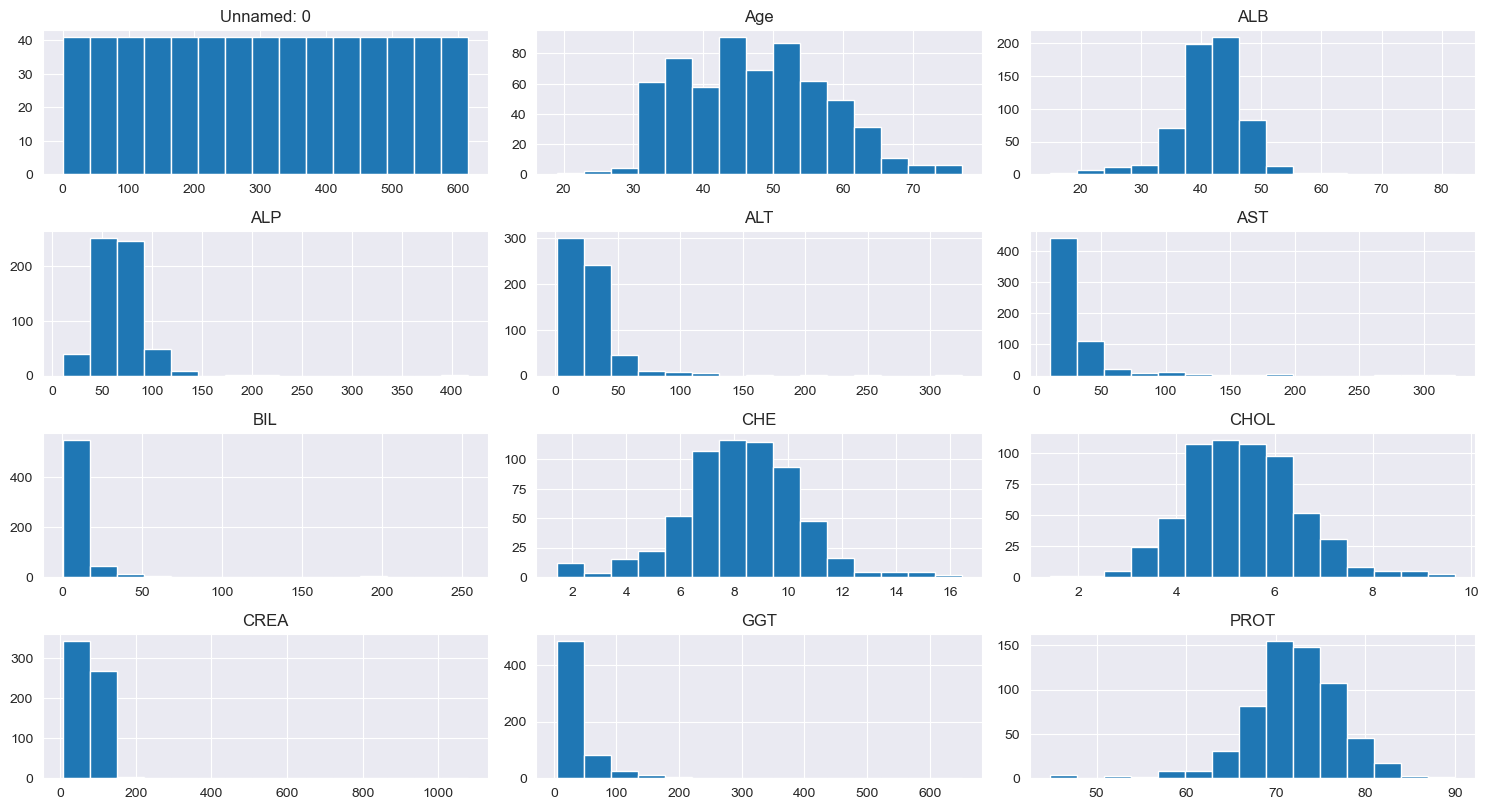

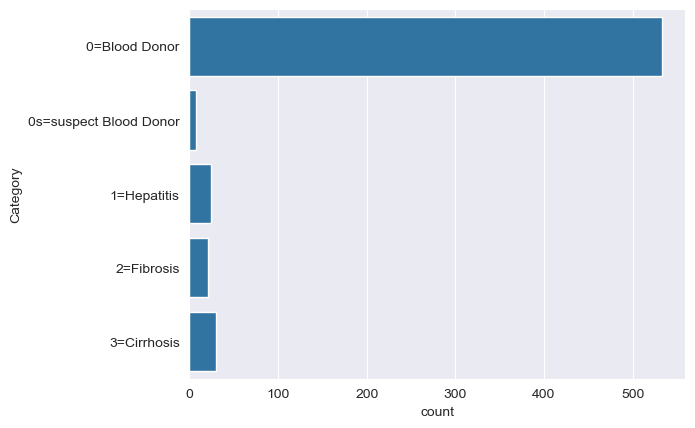

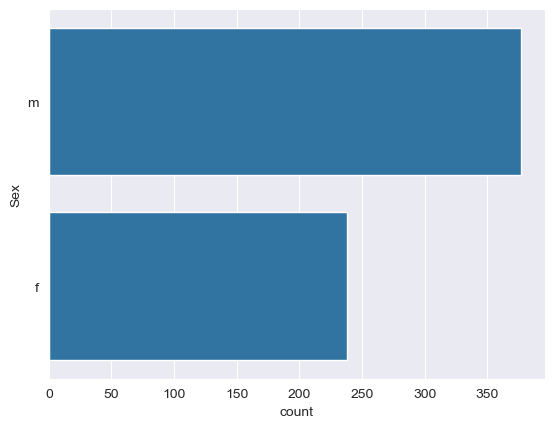

In [24]:
# 3. Distribution Analysis
numerical_columns = df.select_dtypes(include=[np.number]).columns

# Histograms for numerical data
df[numerical_columns].hist(bins=15, figsize=(15, 10), layout=(len(numerical_columns)//3 + 1, 3))
plt.tight_layout()
plt.show()

# Count plots for categorical data
for col in categorical_columns:
    sns.countplot(y=col, data=df)
    plt.show()

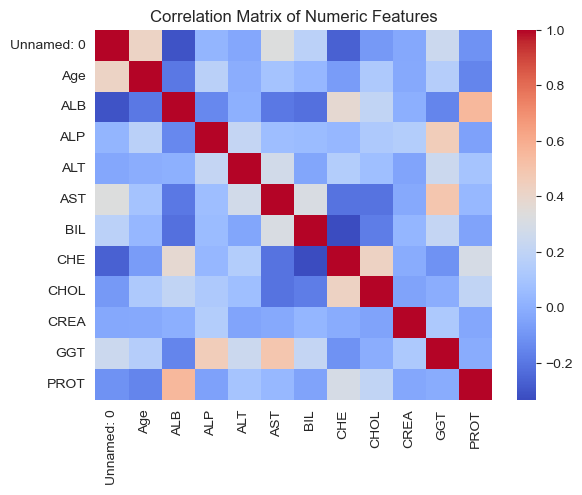

In [25]:
# 4. Correlation Matrix
# Select only numeric columns for correlation matrix
numeric_columns = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_columns].corr()

# Visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

In [26]:
# 5. Feature Engineering Insights
print("\nUnique Values per Column:")
print(df.nunique())


Unique Values per Column:
Unnamed: 0    615
Category        5
Age            49
Sex             2
ALB           189
ALP           414
ALT           341
AST           297
BIL           188
CHE           407
CHOL          313
CREA          117
GGT           358
PROT          198
dtype: int64


In [27]:
# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Calculate the number of missing values for each feature
missing_values = df.isnull().sum()

# Output the count of missing values for each feature
print("Missing values per feature:")
for feature, missing_count in missing_values.items():
    print(f"{feature}: {missing_count}")

Missing values per feature:
Unnamed: 0: 0
Category: 0
Age: 0
Sex: 0
ALB: 1
ALP: 18
ALT: 1
AST: 0
BIL: 0
CHE: 0
CHOL: 10
CREA: 0
GGT: 0
PROT: 1


In [28]:
# Define the KNN imputer
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')

# Apply KNN imputer to the DataFrame
numerical_columns = df.select_dtypes(include=['number']).columns
df[numerical_columns] = knn_imputer.fit_transform(df[numerical_columns])

# Check if all null values are imputed
foundNull = df.isnull().values.any()
if foundNull:
    raise TypeError('Found null value in DataFrame.')

# Output the cleaned DataFrame
print("DataFrame after KNN imputation:")
print(df)

DataFrame after KNN imputation:
     Unnamed: 0       Category   Age Sex   ALB     ALP    ALT    AST   BIL  \
0           1.0  0=Blood Donor  32.0   m  38.5   52.50    7.7   22.1   7.5   
1           2.0  0=Blood Donor  32.0   m  38.5   70.30   18.0   24.7   3.9   
2           3.0  0=Blood Donor  32.0   m  46.9   74.70   36.2   52.6   6.1   
3           4.0  0=Blood Donor  32.0   m  43.2   52.00   30.6   22.6  18.9   
4           5.0  0=Blood Donor  32.0   m  39.2   74.10   32.6   24.8   9.6   
..          ...            ...   ...  ..   ...     ...    ...    ...   ...   
610       611.0    3=Cirrhosis  62.0   f  32.0  416.60    5.9  110.3  50.0   
611       612.0    3=Cirrhosis  64.0   f  24.0  102.80    2.9   44.4  20.0   
612       613.0    3=Cirrhosis  64.0   f  29.0   87.30    3.5   99.0  48.0   
613       614.0    3=Cirrhosis  46.0   f  33.0   48.42   39.0   62.0  20.0   
614       615.0    3=Cirrhosis  59.0   f  36.0   40.64  100.0   80.0  12.0   

       CHE  CHOL   CREA    GGT 

In [29]:
# Select numerical columns
numerical_columns = df.select_dtypes(include=['number']).columns
df_numerical = df[numerical_columns]

# Create a copy of the original data
original_data = df_numerical.copy()

# Introduce missing values artificially (10% missing)
np.random.seed(42)
mask = np.random.rand(*df_numerical.shape) < 0.1  # Mask for 10% missing
df_missing = df_numerical.copy()
df_missing[mask] = np.nan

# Apply KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')
df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_missing), columns=numerical_columns)

# Compare imputed values with original values
print(f"Mean Squared Error for each feature:")
for col in numerical_columns:
    # Calculate error only for artificially missing values
    mask_col = mask[:, df_numerical.columns.get_loc(col)]
    mse = mean_squared_error(original_data[col][mask_col], df_imputed[col][mask_col])
    print(f"'{col}': {mse}")

Mean Squared Error for each feature:
'Unnamed: 0': 21078.87642857143
'Age': 46.33243243243243
'ALB': 36.52073488372093
'ALP': 425.4499006666667
'ALT': 217.95315409836067
'AST': 350.74518235294124
'BIL': 219.87170793650796
'CHE': 4.497813692307693
'CHOL': 1.4609084950943398
'CREA': 445.13446567164175
'GGT': 2974.071109433962
'PROT': 33.07476250000002


## 1. Anomaly Detection
Since medical conditions that lead to the rejection of a donor are rare (luckily) and can be very
versatile. It is near impossible to categorize every possible condition. Hence, it would be useful to have an anomaly
detection algorithm in place as a safety mechanism to detect suspicious blood samples for further testing.
- Train an anomaly detection model based only on valid blood donors without a medical condition.
- Evaluate the accuracy of your anomaly detection by testing it also on donors with a medical condition.
- Perform a PCA to visualize the true / false positive and true / false negative predictions as well as the decision
boundary of your anomaly detection. How much variance is explained by the first two main components? 

Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.56      0.85      0.68        82
       Valid       0.98      0.90      0.94       533

    accuracy                           0.89       615
   macro avg       0.77      0.88      0.81       615
weighted avg       0.92      0.89      0.90       615

Variance explained by the first two components: [0.43570755 0.29025185]


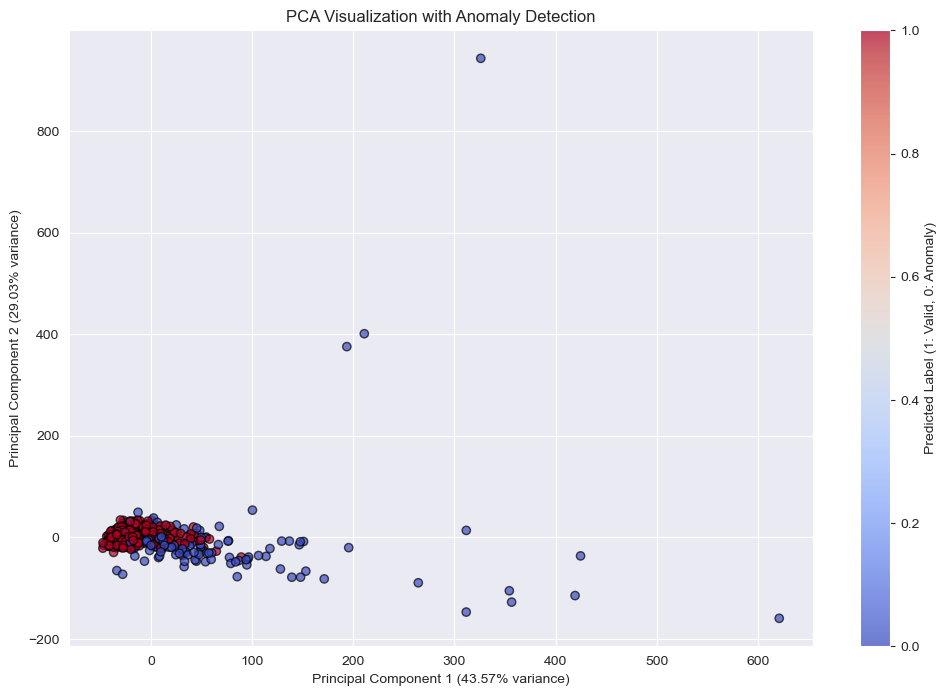

In [30]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA


# Filter data for valid blood donors
donors = df[df['Category'] == '0=Blood Donor']

# Filter data for non-donors (anomalous category)
non_donors = df[df['Category'] != '0=Blood Donor']

# Numerical columns for modeling
numerical_columns = ['ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT']

# Features for anomaly detection
X_train = donors[numerical_columns]  # Train on valid donors only
X_test = non_donors[numerical_columns]  # Use non-donors for testing

# Define and train Isolation Forest
iso_forest = IsolationForest(random_state=42, contamination=0.1)  # Assuming 10% contamination
iso_forest.fit(X_train)

# Predict anomalies on the combined dataset
combined_data = pd.concat([donors, non_donors], axis=0)
combined_features = combined_data[numerical_columns]
predictions = iso_forest.predict(combined_features)

# Map predictions to binary format (1: normal, -1: anomaly)
pred_binary = np.where(predictions == 1, 1, 0)  # 1: Valid, 0: Anomaly
true_labels = np.where(combined_data['Category'] == '0=Blood Donor', 1, -1)
true_binary = np.where(true_labels == 1, 1, 0)

# Classification report
print("Classification Report:")
print(classification_report(true_binary, pred_binary, target_names=['Anomaly', 'Valid']))


# Perform PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(combined_features)

# Variance explained by PCA components
variance_explained = pca.explained_variance_ratio_
print(f"Variance explained by the first two components: {variance_explained}")

# Scatter plot with PCA results
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    pca_data[:, 0], pca_data[:, 1],
    c=pred_binary,  # Color based on predictions
    cmap='coolwarm',
    alpha=0.7,
    edgecolor='k'
)
plt.colorbar(scatter, label='Predicted Label (1: Valid, 0: Anomaly)')
plt.title("PCA Visualization with Anomaly Detection")
plt.xlabel(f"Principal Component 1 ({variance_explained[0]:.2%} variance)")
plt.ylabel(f"Principal Component 2 ({variance_explained[1]:.2%} variance)")
plt.grid(True)
plt.show()


## 2. Explainable Model
For your decision support your model should be explainable. Train a model with a focus on
explainability with an as simple as possible structure while still maintaining its predictive power.
- Train a decision tree classifier on the imputed data. Evaluate your model’s accuracy and visualize the tree structure to
help the hospital personal understand the decision process. Each inference should not only put out the class, but also
the decision path taken. Make the tree as simple and understandable as possible.

## 3. High Performance Model
This time the focus is on predictive power. Try and train a more accurate model. Is it worth
the effort?
- Train and optimize an XGBoost classifier on the imputed data.
- Use SHAP local explanation techniques on 5 selected data points and discuss the results
- Use SHAP global explanation techniques to visualize and discuss the influence of different features.
- Evaluate the XGBoost’s accuracy and compare it to the Decision Tree

## 4. Combined Model
Put all components into a single model artifact for deployment such that clinic personal has all important
information at hand to make an informed decision.
- Combine the XGBoost, Decision Tree and Anomaly Detection in a single model class including all necessary methods (fit,
predict…). The Decision Tree provides an explainable assistance for the hospital personal and the XGBoost (probably) a more
accurate classification. The Anomaly Detection increases the robustness of the model for conditions that have not been
explicitly trained or for human errors. Generate a few test anomalies to check your detection.
- Evaluate, discuss and plot the performance of your combined model.